In [27]:
import cv2
import h5py
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

from prolev import init_event_model, load_weights_ckpt
from prolev.utils import setup_torch, plot_patched_features, ev_to_frames

# path = "out/sim_data_00014.h5"
path = "out/sim_data_skok.h5"
h5file = h5py.File(path, "r")

# end_time = 25000 # in ms
end_time = 15000  # in ms

In [28]:
setup_torch(cudnn_benchmark=True)

cfg = "models/dsec_featurizer/config.yml"
ckpt = "models/dsec_featurizer/last.pth"

model = init_event_model(cfg, return_feat=True).cuda()
model = torch.compile(model)
load_weights_ckpt(model, ckpt)

(199, 0.0060819502031232734, tensor(0.7924, device='cuda:0'))

In [29]:
def get_ctx_events(
    ms: int, t_ctx: int = 20, h: int = 480, w: int = 640
) -> torch.Tensor:
    """
    Get the context events for a given millisecond and context time window in ms.
    """
    s_idx = h5file["ms_idx"][ms - t_ctx]
    e_idx = h5file["ms_idx"][ms]
    ctx_events = np.zeros((e_idx - s_idx, 3), dtype=np.float32)
    ctx_events[:, 0] = h5file["x"][s_idx:e_idx]
    ctx_events[:, 1] = h5file["y"][s_idx:e_idx]
    ctx_events[:, 2] = (ms * 1e3 - h5file["t"][s_idx:e_idx]) / 1e3
    ctx_events = torch.from_numpy(ctx_events)
    ctx_events = ctx_events / torch.tensor([w, h, t_ctx], dtype=torch.float32)
    ctx_counts = torch.tensor([ctx_events.shape[0]], dtype=torch.int32)

    return ctx_events, ctx_counts

In [30]:
h5file["ms_idx"][8840]

np.uint64(38779687)

In [31]:
ctx_events, ctx_counts = get_ctx_events(8000)
ctx_events, ctx_counts = ctx_events.cuda(), ctx_counts.cuda()

PCA result shape: (480, 640, 3)


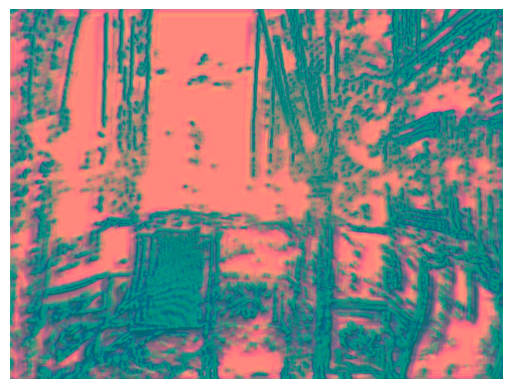

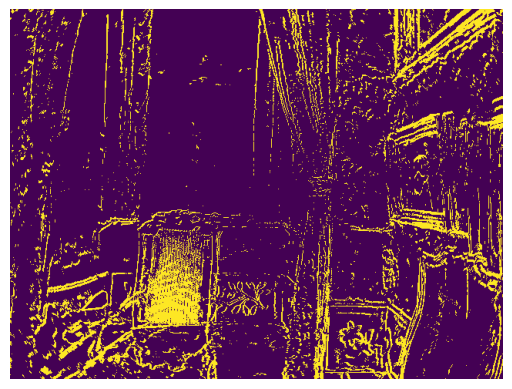

In [32]:
with torch.no_grad():
    logits, feat = model(ctx_events, ctx_counts)
feat = feat[0].permute(1, 0, 2).cpu().numpy()
pca_result, _ = plot_patched_features(feat, plot=False)
print("PCA result shape:", pca_result.shape)
plt.imshow(pca_result)
plt.axis("off")
plt.show()
evframe = ev_to_frames(ctx_events, ctx_counts, 640, 480)
plt.imshow(evframe[0].T.cpu().numpy())
plt.axis("off")
plt.show()

### Video of features

In [33]:
out = cv2.VideoWriter("out/video.avi", cv2.VideoWriter_fourcc(*"HFYU"), 25, (640, 480))

for t0 in tqdm(range(1000, end_time, 40)):
    ctx_events, ctx_counts = get_ctx_events(t0)
    ctx_events, ctx_counts = ctx_events.cuda(), ctx_counts.cuda()
    with torch.no_grad():
        logits, feat = model(ctx_events, ctx_counts)
    feat = feat[0].permute(1, 0, 2).cpu().numpy()
    pca_result, _ = plot_patched_features(feat, plot=False)
    evframe = ev_to_frames(ctx_events, ctx_counts, 640, 480)
    evframe = evframe[0].T.cpu().numpy()
    out.write(pca_result[..., ::-1])
out.release()

  1%|          | 2/350 [00:00<00:29, 11.93it/s]

100%|██████████| 350/350 [00:33<00:00, 10.47it/s]


## Optical flow

In [34]:
from prolev.tasks.optical_flow.utils import EventFFFlow, flow_viz_np

flowckpt = "models/optflow_traindsec_20msff_pyr4_28k/models/checkpoint_99.pth"

flowmodel = EventFFFlow(
    cfg,
    flowhead_config={
        "kernels": [9, 9, 9, 9],
        "btlncks": [2, 2, 2, 2],
        "dilations": [2, 2, 2, 1],
    },
).cuda()
flowmodel.eventff = torch.compile(flowmodel.eventff)
flowmodel.flowhead = torch.compile(flowmodel.flowhead)

last_dict = torch.load(flowckpt, weights_only=False)
flowmodel.load_state_dict(last_dict["model"])
last_epoch = last_dict["epoch"]
last_loss = last_dict["loss"]
del last_dict
torch.cuda.empty_cache()
print(f"Loaded model from: {flowckpt}, Epoch: {last_epoch}, Loss: {last_loss}")

flowmodel.eval()

Loaded model from: models/optflow_traindsec_20msff_pyr4_28k/models/checkpoint_99.pth, Epoch: 99, Loss: 0.003041285080536175


EventFFFlow(
  (eventff): OptimizedModule(
    (_orig_mod): EventPatchFF(
      (multi_hash_encoder): MultiResolutionHashEncoder()
      (downsample_layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): LayerNorm()
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (stages): ModuleList(
        (0-1): 2 x Sequential(
          (0): Block(
            (dwconv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=32)
            (norm): LayerNorm()
            (pwconv1): Linear(in_features=32, out_features=64, bias=True)
            (act): GELU(approximate='none')
            (grn): GRN()
            (pwconv2): Linear(in_features=64, out_features=32, bias=True)
            (drop_path): Identity()
          )
          (1): Block(
            (dwconv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1)

In [35]:
out = cv2.VideoWriter(
    "out/video_flow.avi", cv2.VideoWriter_fourcc(*"HFYU"), 25, (640, 480)
)

for t0 in tqdm(range(1000, end_time, 40)):
    ctx_events, ctx_counts = get_ctx_events(t0)
    ctx_events, ctx_counts = ctx_events.cuda(), ctx_counts.cuda()
    with torch.no_grad():
        flow_pred, ffflow = flowmodel(ctx_events, ctx_counts)
    flow_rgb = flow_viz_np(flow_pred[0].permute(1, 2, 0).cpu().numpy())
    evframe = ev_to_frames(ctx_events, ctx_counts, 640, 480)
    evframe = evframe[0].T.cpu().numpy() == 255
    flow_rgb[~evframe] = 0
    out.write(flow_rgb)
out.release()

  0%|          | 0/350 [00:00<?, ?it/s]

100%|██████████| 350/350 [00:10<00:00, 33.62it/s]


## Depth

In [36]:
from prolev.tasks.depth.utils import EventFFDepthAnythingV2, get_disparity_image

event_cfg = "models/patchff_fullcardaym3ed_small_20ms/models/config.yml"
depthckpt = "models/dav2b_fullm3ed_pseudo_518x518x20/models/last.pth"

depthmodel = EventFFDepthAnythingV2(
    event_cfg,
    dav2_config={
        "encoder": "vitb",
        "size": 518,
    },
)
depthmodel.eventff = torch.compile(depthmodel.eventff, fullgraph=False)

last_dict = torch.load(depthckpt)
depthmodel.load_state_dict(last_dict["model"])
epoch = last_dict["epoch"]
results = last_dict["results"]
del last_dict
torch.cuda.empty_cache()
print(f"Loaded model from: {depthckpt}, Epoch: {epoch}, Results: {results}")
depthmodel.eval()

Loaded model from: models/dav2b_fullm3ed_pseudo_518x518x20/models/last.pth, Epoch: 99, Results: {'d1': tensor([0.0866], device='cuda:0'), 'd2': tensor([0.0866], device='cuda:0'), 'd3': tensor([0.0866], device='cuda:0'), 'abs_rel': tensor([42979896.], device='cuda:0'), 'sq_rel': tensor([1.8416e+12], device='cuda:0'), 'rmse': tensor([101139.3906], device='cuda:0'), 'rmse_log': tensor([6.0727], device='cuda:0'), 'log10': tensor([2.4827], device='cuda:0'), 'silog': tensor([4.5631], device='cuda:0'), 'ssimae': tensor([0.1626], device='cuda:0')}


EventFFDepthAnythingV2(
  (dav2): DepthAnythingV2(
    (pretrained): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(32, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_

In [37]:
cmap = cm.get_cmap("magma")
out = cv2.VideoWriter(
    "out/video_depth.avi", cv2.VideoWriter_fourcc(*"HFYU"), 25, (640, 480)
)

for t0 in tqdm(range(1000, end_time, 40)):
    ctx_events, ctx_counts = get_ctx_events(t0)
    ctx_events, ctx_counts = ctx_events.cuda(), ctx_counts.cuda()
    # need to center the events in 720x1280
    cparams = torch.tensor([120, 320, 600, 960], dtype=torch.int32)
    offset = [(1280 - 640) // 2, (720 - 480) // 2]
    ctx_events[:, 0] = (ctx_events[:, 0] * 640 + offset[0]) / 1280
    ctx_events[:, 1] = (ctx_events[:, 1] * 480 + offset[1]) / 720
    with torch.no_grad():
        depth_pred, ff = depthmodel.infer_image(ctx_events, ctx_counts, cparams=cparams)
    mean, std = depth_pred.mean(), depth_pred.std()
    depth_pred = torch.clamp(depth_pred, mean - 2 * std, mean + 2 * std)
    depth_rgb = get_disparity_image(
        depth_pred, torch.ones_like(depth_pred, dtype=bool), cmap
    )
    out.write(depth_rgb)
out.release()

  0%|          | 0/350 [00:00<?, ?it/s]

100%|██████████| 350/350 [00:16<00:00, 20.79it/s]
